In [2]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import copy
import pickle

from mrsc.src.model.SVDmodel import SVDmodel
from mrsc.src.model.Target import Target
from mrsc.src.model.Donor import Donor
from mrsc.src.synthcontrol.mRSC import mRSC
from mrsc.src.importData import *
import mrsc.src.utils as utils

from itertools import combinations, product

In [3]:
def getActivePlayers(stats, year, buffer):
    # list of name of the players who were active in this and last year
    thisYear = stats[stats.Year == year].copy()
    players = list(thisYear.Player.unique())
    for i in range(1, buffer+1):
        previousYear = stats[stats.Year == (year-i)].copy()
        players = list(set(players) & set(previousYear.Player.unique()))
    return players

def topPlayers(stats, year, metric, n):
    stats = stats[stats.Year == year]
    stats = stats.groupby('Player').mean().reset_index()
    stats_sorted = stats[stats.Year == year].sort_values(metric, ascending = False).reset_index(drop=True)
    return stats_sorted[["Player","player_id"]][:n]

def removeDuplicated(players, stats):
    """
    players: "../data/nba-players-stats/player_data.csv"
    stats: "../data/nba-players-stats/Seasons_Stats.csv"
    """
    # players with the same name
    names = players.name.unique()
    duplicated = np.array([])

    for name in names:
        numrows = len(players[players.name == name])
        if numrows != 1:
            duplicated = np.append(duplicated, name)

    duplicated = np.sort(duplicated)

    start_year = players.copy()
    start_year = start_year.rename(columns={"name":"Player"})

    # for non-duplicated players
    stats_not_duplicated = stats[~stats.Player.isin(duplicated)]
    stats_not_duplicated = pd.merge(stats_not_duplicated, start_year, on="Player", how="left")

    # only take the values that make sense
    stats_not_duplicated = stats_not_duplicated[(stats_not_duplicated.Year >= stats_not_duplicated.year_start) & (stats_not_duplicated.Year <= stats_not_duplicated.year_end )]
    stats_not_duplicated["year_count"] = stats_not_duplicated.Year - stats_not_duplicated.year_start

    return stats_not_duplicated

def getMetrics(target, donor, pred_year, allMetrics, threshold, expSetup):
    target_data = target.concat(allMetrics, pred_year, pred_length=1)

    num_k = len(allMetrics)
    total_index = int(target_data.shape[1] / num_k)
    mat_form_method = expSetup[0]

    metrics_list = []
    for metric_of_interest in allMetrics:
        df = donor.concat([metric_of_interest], 2016, total_index, method = mat_form_method)
        apprx_rank = utils.approximate_rank(df, t = threshold)
        energy_captured = utils.svdAanlysis(df, title=metric_of_interest, verbose = False)[apprx_rank-1]

        metrics = [metric_of_interest]
        candidates = copy.deepcopy(allMetrics)
        candidates.remove(metric_of_interest)

        while True:
            energy_diff_df = pd.DataFrame()
            for metric in candidates:
                comb = metrics+[metric]
                df = donor.concat(comb, 2016, total_index, method = mat_form_method)
                energy_at_apprx_rank = utils.svdAanlysis(df, k=apprx_rank, verbose=False)[-1]
                
                if(energy_at_apprx_rank > threshold):
                    energy_diff = np.abs(energy_at_apprx_rank - energy_captured)
                    energy_diff_df = pd.concat([energy_diff_df, pd.DataFrame([[energy_diff]], index=[metric])], axis=0)
        #             print(energy_diff)
            if (energy_diff_df.shape[0] == 0):
                break
            new_metric = energy_diff_df.sort_values(0).index[0]
            metrics = metrics + [new_metric]
            candidates.remove(new_metric)
        metrics_list.append(metrics)
        print(metrics)

    return metrics_list

def getWeitghts(target, donor, metrics_list, expSetup, method = "mean"):   
    # get mat_form_method
    mat_form_method = expSetup[0] # "fixed"

    # get weights for metrics
    weights_list = []
    for metrics in metrics_list:
        target_data = target.concat(metrics, 2016, pred_length=1)
        num_k = len(metrics)
        total_index = int(target_data.shape[1] / num_k)
        donor_data = donor.concat(metrics, 2016, total_index, method = mat_form_method)

        if (method == "mean"):
            weights = []
            for i in range(num_k):
                weights.append(1/(donor_data.iloc[:,i*total_index:(i+1)*total_index].mean().mean()))
            weights_list.append(weights)
        elif (method == "var"):
            weights = []
            for i in range(num_k):
                weights.append(1/(1+np.var(donor_data.iloc[:,i*total_index:(i+1)*total_index].to_numpy().flatten())))
            weights_list.append(weights)
        else:
            raise ValueError("invalid method")
    return weights_list

# Clean Data

In [4]:
"""
import data
"""
players = pd.read_csv("../data/nba-players-stats/player_data.csv")
players = players[players.year_start >= 1980] # only choose players who started after 1980
players["player_id"] = range(0,len(players.name)) # assign id

stats = pd.read_csv("../data/nba-players-stats/Seasons_Stats.csv")
stats = stats[stats.Player.isin(players.name)]

# only after 1980
stats = stats[stats.Year >= 1980]

# without duplicated names --> to do: how to distinguish multiple player with the same name
stats = removeDuplicated(players, stats)
stats.Year = stats.Year.astype(int)
stats.year_count = stats.year_count.astype(int)

# transform stats to a dictionary composed of df's for each stat
# the stats are re-calculated to get one stat for each year

metricsPerGameColNames = ["PTS","AST","TOV","TRB","STL","BLK","3P"]
metricsPerGameDict = getMetricsPerGameDict(stats, metricsPerGameColNames)

metricsPerCentColNames = ["FG","FT"]
metricsPerCentDict = getMetricsPerCentDict(stats, metricsPerCentColNames)

metricsWeightedColNames = ["PER"]
metricsWeightedDict = getMetricsWeightedDict(stats, metricsWeightedColNames)

allMetricsDict = {**metricsPerGameDict, **metricsPerCentDict, **metricsWeightedDict}
allPivotedTableDict = getPivotedTableDict(allMetricsDict)
allMetrics = list(allMetricsDict.keys())

# this matrix will be used to mask the table
df_year = pd.pivot_table(stats, values="Year", index="Player", columns = "year_count")

In [5]:
allMetrics

['PTS_G',
 'AST_G',
 'TOV_G',
 'TRB_G',
 'STL_G',
 'BLK_G',
 '3P_G',
 'FG%',
 'FT%',
 'PER_w']

In [6]:
pred_year = 2016
# targets to test
activePlayers = getActivePlayers(stats, pred_year, 4)
activePlayers.sort()
# to few donors
activePlayers.remove("Kevin Garnett")
activePlayers.remove("Kobe Bryant")

# overall setup
expSetup = ["sliding", "SVD", "all", "pinv", False]
threshold = 0.97

# Baseline

In [7]:
metrics_to_use= ["PTS_G","AST_G","TOV_G","PER_w", "FG%","FT%","3P_G","TRB_G","STL_G","BLK_G"]

print("Algo: outputs the mean of the player's history")
print("-----")
pred_all = pd.DataFrame()
true_all = pd.DataFrame()
for playerName in activePlayers:
    target = Target(playerName, allPivotedTableDict, df_year)
    target_data = target.concat(metrics_to_use, 2016, pred_length=1)
    num_k = len(metrics_to_use)
    interv_index = int(target_data.shape[1]/num_k -1)
    total_index = int(interv_index + 1)

    # true
    true = utils.get_postint_data(target_data, interv_index, total_index, num_k).T
    true.index = metrics_to_use

    # predictions
    history = utils.get_preint_data(target_data, interv_index, total_index, num_k)
    pred = []
    for i in range(num_k):
        pred.append(history.iloc[:,i*interv_index:(i+1)*interv_index].mean(axis=1).to_list())

    pred = pd.DataFrame(pred, index=metrics_to_use, columns = [playerName])

    pred_all = pd.concat([pred_all, pred], axis=1)
    true_all = pd.concat([true_all, true], axis=1)

###################
mask = (true_all !=0 )
mape = np.abs(pred_all - true_all) / true_all[mask]
print("*** MAPE ***")
print(mape.mean(axis=1))
print("MAPE for all: ", mape.mean().mean())
rmse = utils.rmse_2d(true_all, pred_all)
print()
print("*** RMSE ***")
print(rmse)
print("RMSE for all: ", rmse.mean())    

Algo: outputs the mean of the player's history
-----
*** MAPE ***
PTS_G    0.575711
AST_G    0.506711
TOV_G    0.596790
PER_w    0.287966
FG%      0.076904
FT%      0.081673
3P_G     0.682272
TRB_G    0.422301
STL_G    0.446710
BLK_G    0.685350
dtype: float64
MAPE for all:  0.4420163650526481

*** RMSE ***
PTS_G    4.691799
AST_G    1.136067
TOV_G    0.617640
PER_w    3.788750
FG%      0.052942
FT%      0.110670
3P_G     0.503330
TRB_G    1.709996
STL_G    0.299601
BLK_G    0.282306
dtype: float64
RMSE for all:  1.3193101146400346


In [39]:
metrics_to_use= ["PTS_G","AST_G","TOV_G","PER_w", "FG%","FT%","3P_G","TRB_G","STL_G","BLK_G"]

print("Algo: outputs the donor mean")
print("-----")
pred_all = pd.DataFrame()
true_all = pd.DataFrame()

for playerName in activePlayers:
    target = Target(playerName, allPivotedTableDict, df_year)
    target_data = target.concat(metrics_to_use, 2016, pred_length=1)
    num_k = len(metrics_to_use)
    total_index = int(target_data.shape[1] / num_k)

    donor = Donor(allPivotedTableDict, df_year)
    donor_data = donor.concat(metrics_to_use, 2016, total_index, method = "sliding")
    interv_index = int(target_data.shape[1]/num_k -1)

    # true
    true = utils.get_postint_data(target_data, interv_index, total_index, num_k).T
    true.index = metrics_to_use

    # predictions
    pred = utils.get_postint_data(donor_data, interv_index, total_index, num_k).mean().values
    pred = pd.DataFrame(pred, index=metrics_to_use, columns = [playerName])

    pred_all = pd.concat([pred_all, pred], axis=1)
    true_all = pd.concat([true_all, true], axis=1)

###################
mask = (true_all !=0 )
mape = np.abs(pred_all - true_all) / true_all[mask]
print("*** MAPE ***")
print(mape.mean(axis=1))
print("MAPE for all: ", mape.mean().mean())
rmse = utils.rmse_2d(true_all, pred_all)
print()
print("*** RMSE ***")
print(rmse)
print("RMSE for all: ", rmse.mean())    

Algo: outputs the donor mean
-----
*** MAPE ***
PTS_G    0.638973
AST_G    1.458318
TOV_G    0.783382
PER_w    0.301328
FG%      0.109654
FT%      0.135272
3P_G     2.068981
TRB_G    0.558484
STL_G    0.687445
BLK_G    1.466053
dtype: float64
MAPE for all:  0.80598857327121

*** RMSE ***
PTS_G    6.154653
AST_G    2.073663
TOV_G    0.840562
PER_w    5.132207
FG%      0.076097
FT%      0.135968
3P_G     0.847029
TRB_G    2.439111
STL_G    0.466710
BLK_G    0.426690
dtype: float64
RMSE for all:  1.8592689956202508


In [40]:
metrics_to_use= ["PTS_G","AST_G","TOV_G","PER_w", "FG%","FT%","3P_G","TRB_G","STL_G","BLK_G"]

print("Algo: outputs the donor mean")
print("-----")
pred_all = pd.DataFrame()
true_all = pd.DataFrame()

for playerName in activePlayers:
    target = Target(playerName, allPivotedTableDict, df_year)
    target_data = target.concat(metrics_to_use, 2016, pred_length=1)
    num_k = len(metrics_to_use)
    total_index = int(target_data.shape[1] / num_k)

    donor = Donor(allPivotedTableDict, df_year)
    donor_data = donor.concat(metrics_to_use, 2016, total_index, method = "fixed")
    interv_index = int(target_data.shape[1]/num_k -1)

    # true
    true = utils.get_postint_data(target_data, interv_index, total_index, num_k).T
    true.index = metrics_to_use

    # predictions
    pred = utils.get_postint_data(donor_data, interv_index, total_index, num_k).mean().values
    pred = pd.DataFrame(pred, index=metrics_to_use, columns = [playerName])

    pred_all = pd.concat([pred_all, pred], axis=1)
    true_all = pd.concat([true_all, true], axis=1)

###################
mask = (true_all !=0 )
mape = np.abs(pred_all - true_all) / true_all[mask]
print("*** MAPE ***")
print(mape.mean(axis=1))
print("MAPE for all: ", mape.mean().mean())
rmse = utils.rmse_2d(true_all, pred_all)
print()
print("*** RMSE ***")
print(rmse)
print("RMSE for all: ", rmse.mean())    

Algo: outputs the donor mean
-----
*** MAPE ***
PTS_G    0.709844
AST_G    1.601052
TOV_G    0.870653
PER_w    0.305483
FG%      0.111015
FT%      0.134692
3P_G     2.090757
TRB_G    0.599728
STL_G    0.758644
BLK_G    1.598600
dtype: float64
MAPE for all:  0.8651101234839497

*** RMSE ***
PTS_G    5.967478
AST_G    2.054456
TOV_G    0.834331
PER_w    4.917344
FG%      0.074297
FT%      0.134823
3P_G     0.845384
TRB_G    2.422621
STL_G    0.461972
BLK_G    0.425583
dtype: float64
RMSE for all:  1.8138289637862326


### Off vs. Def

In [7]:
def getWeitghts(target, donor, metrics_list, expSetup, method = "mean"):   
    # get mat_form_method
    mat_form_method = expSetup[0] # "fixed"
    
    # get weights for metrics
    weights_list = []
    for metrics in metrics_list:
        target_data = target.concat(metrics, 2016, pred_length=1)
        num_k = len(metrics)
        total_index = int(target_data.shape[1] / num_k)
        donor_data = donor.concat(metrics, 2016, total_index, method = mat_form_method)
    
        if (method == "mean"):
            weights = []
            for i in range(num_k):
                weights.append(1/(donor_data.iloc[:,i*total_index:(i+1)*total_index].mean().mean()))
            weights_list.append(weights)
        elif (method == "var"):
            weights = []
            for i in range(num_k):
                weights.append(1/(1+np.var(donor_data.iloc[:,i*total_index:(i+1)*total_index].to_numpy().flatten())))
            weights_list.append(weights)
        else:
            raise ValueError("invalid method")
    return weights_list

In [8]:
offMetrics = ["PTS_G","AST_G","TOV_G","PER_w", "FG%","FT%","3P_G"]
defMetrics = ["TRB_G","STL_G","BLK_G"]
metrics_list = [offMetrics, defMetrics]

print("start experiment - off/def with mean-standardized weights")
pred_all = pd.DataFrame()
true_all = pd.DataFrame()
for playerName in activePlayers:
    target = Target(playerName, allPivotedTableDict, df_year)
    donor = Donor(allPivotedTableDict, df_year)
    
    weights_list = getWeitghts(target, donor, metrics_list, expSetup, method="mean")

    mrsc = mRSC(donor, target, probObservation=1)
    mrsc.fit_threshold(offMetrics, weights_list[0], 2016, pred_length = 1, threshold = threshold, setup = expSetup)

    predOff = mrsc.predict()
    trueOff = mrsc.getTrue()
    predOff.columns = [playerName]
    trueOff.columns = [playerName]

    mrsc.fit_threshold(defMetrics, weights_list[1], 2016, pred_length = 1, threshold = threshold, setup = expSetup)
    predDef = mrsc.predict()
    trueDef = mrsc.getTrue()
    predDef.columns = [playerName]
    trueDef.columns = [playerName]

    pred = pd.concat([predOff, predDef], axis=0)
    true = pd.concat([trueOff, trueDef], axis=0)

    pred_all = pd.concat([pred_all, pred], axis=1)
    true_all = pd.concat([true_all, true], axis=1)

###################
mask = (true_all !=0 )
mape = np.abs(pred_all - true_all) / true_all[mask]
print("*** MAPE ***")
print(mape.mean(axis=1))
print("MAPE for all: ", mape.mean().mean())
rmse = utils.rmse_2d(true_all, pred_all)
print()
print("*** RMSE ***")
print(rmse)
print("RMSE for all: ", rmse.mean())    

start experiment - off/def with mean-standardized weights
*** MAPE ***
PTS_G    0.496740
AST_G    0.501347
TOV_G    0.482180
PER_w    0.260251
FG%      0.144308
FT%      0.159636
3P_G     0.733344
TRB_G    0.304462
STL_G    0.368836
BLK_G    0.551897
dtype: float64
MAPE for all:  0.4017416667362548

*** RMSE ***
PTS_G    4.308476
AST_G    1.068244
TOV_G    0.537453
PER_w    4.044152
FG%      0.091057
FT%      0.164684
3P_G     0.418090
TRB_G    1.457112
STL_G    0.285364
BLK_G    0.220287
dtype: float64
RMSE for all:  1.2594918479759074


In [9]:
offMetrics = ["PTS_G","AST_G","TOV_G","PER_w", "FG%","FT%","3P_G"]
defMetrics = ["TRB_G","STL_G","BLK_G"]
metrics_list = [offMetrics, defMetrics]

print("start experiment - off/def with var-standardized weights")
pred_all = pd.DataFrame()
true_all = pd.DataFrame()
for playerName in activePlayers:
    target = Target(playerName, allPivotedTableDict, df_year)
    donor = Donor(allPivotedTableDict, df_year)
    
    weights_list = getWeitghts(target, donor, metrics_list, expSetup, method="var")

    mrsc = mRSC(donor, target, probObservation=1)
    mrsc.fit_threshold(offMetrics, weights_list[0], 2016, pred_length = 1, threshold = threshold, setup = expSetup)

    predOff = mrsc.predict()
    trueOff = mrsc.getTrue()
    predOff.columns = [playerName]
    trueOff.columns = [playerName]

    mrsc.fit_threshold(defMetrics, weights_list[1], 2016, pred_length = 1, threshold = threshold, setup = expSetup)
    predDef = mrsc.predict()
    trueDef = mrsc.getTrue()
    predDef.columns = [playerName]
    trueDef.columns = [playerName]

    pred = pd.concat([predOff, predDef], axis=0)
    true = pd.concat([trueOff, trueDef], axis=0)

    pred_all = pd.concat([pred_all, pred], axis=1)
    true_all = pd.concat([true_all, true], axis=1)

###################
mask = (true_all !=0 )
mape = np.abs(pred_all - true_all) / true_all[mask]
print("*** MAPE ***")
print(mape.mean(axis=1))
print("MAPE for all: ", mape.mean().mean())
rmse = utils.rmse_2d(true_all, pred_all)
print()
print("*** RMSE ***")
print(rmse)
print("RMSE for all: ", rmse.mean())    

start experiment - off/def with var-standardized weights
*** MAPE ***
PTS_G    0.476088
AST_G    0.642478
TOV_G    0.398136
PER_w    0.256430
FG%      0.123850
FT%      0.137545
3P_G     0.746468
TRB_G    0.317714
STL_G    0.379661
BLK_G    0.587872
dtype: float64
MAPE for all:  0.40813642731548755

*** RMSE ***
PTS_G    4.344855
AST_G    1.102778
TOV_G    0.471909
PER_w    3.934907
FG%      0.081533
FT%      0.148580
3P_G     0.450080
TRB_G    1.455469
STL_G    0.272930
BLK_G    0.224965
dtype: float64
RMSE for all:  1.248800532914943


# grouping

In [10]:
metrics1 = ["PTS_G","PER_w"]
metrics2 = ["TOV_G","FG%","FT%","3P_G"]
metrics3 = ["TRB_G","STL_G",]
metrics4 = ["AST_G","BLK_G"]

metrics_list = [metrics1, metrics2, metrics3, metrics4]
    
print("start experiment - off/def with mean-standardized weights")
pred_all = pd.DataFrame()
true_all = pd.DataFrame()
for playerName in activePlayers:
    target = Target(playerName, allPivotedTableDict, df_year)
    donor = Donor(allPivotedTableDict, df_year)
    
    weights_list = getWeitghts(target, donor, metrics_list, expSetup, method="mean")

    mrsc = mRSC(donor, target, probObservation=1)
    
    player_pred = pd.DataFrame()
    player_true = pd.DataFrame()
    for i in range(len(metrics_list)):
        mrsc.fit_threshold(metrics_list[i], weights_list[i], 2016, pred_length = 1, threshold = threshold, setup = expSetup)
        pred = mrsc.predict()
        true = mrsc.getTrue()
        pred.columns = [playerName]
        true.columns = [playerName]
        player_pred = pd.concat([player_pred, pred], axis=0)
        player_true = pd.concat([player_true, true], axis=0)
        
    pred_all = pd.concat([pred_all, player_pred], axis=1)
    true_all = pd.concat([true_all, player_true], axis=1)

###################
mask = (true_all !=0 )
mape = np.abs(pred_all - true_all) / true_all[mask]
print("*** MAPE ***")
print(mape.mean(axis=1))
print("MAPE for all: ", mape.mean().mean())
rmse = utils.rmse_2d(true_all, pred_all)
print()
print("*** RMSE ***")
print(rmse)
print("RMSE for all: ", rmse.mean())    

start experiment - off/def with mean-standardized weights
*** MAPE ***
PTS_G    0.322071
PER_w    0.226253
TOV_G    0.466952
FG%      0.100906
FT%      0.113409
3P_G     0.716701
TRB_G    0.318915
STL_G    0.383144
AST_G    0.397755
BLK_G    0.499905
dtype: float64
MAPE for all:  0.3559113974311001

*** RMSE ***
PTS_G    3.217899
PER_w    3.286641
TOV_G    0.556341
FG%      0.070517
FT%      0.128724
3P_G     0.475833
TRB_G    1.486316
STL_G    0.272537
AST_G    0.962288
BLK_G    0.217640
dtype: float64
RMSE for all:  1.0674735892947658


## grouping - automatic

In [146]:
def getMetrics(target, donor, pred_year, allMetrics, threshold, expSetup, boundary = "threshold"):
    target_data = target.concat(allMetrics, pred_year, pred_length=1)

    num_k = len(allMetrics)
    total_index = int(target_data.shape[1] / num_k)
    mat_form_method = expSetup[0]
    
    df_result = pd.DataFrame(0, columns = allMetrics, index = allMetrics)
    for metric_of_interest in allMetrics:
        df = donor.concat([metric_of_interest], 2016, total_index, method = mat_form_method)
        apprx_rank = utils.approximate_rank(df, t = threshold)
        energy_captured = utils.svdAanlysis(df, title=metric_of_interest, verbose = False)[apprx_rank-1]

        if (boundary == "threshold"):
            b = threshold
        elif (boundary == "energy"):
            b = energy_captured
        else:
            raise Exception("wrong parameter")

        metrics = [metric_of_interest]
        candidates = copy.deepcopy(allMetrics)
        candidates.remove(metric_of_interest)

        while True:
            energy_diff_df = pd.DataFrame()
            for metric in candidates:
                comb = metrics+[metric]
                df = donor.concat(comb, 2016, total_index, method = mat_form_method)
                energy_at_apprx_rank = utils.svdAanlysis(df, k=apprx_rank, verbose=False)[-1]
                
                if(energy_at_apprx_rank > b):
                    energy_diff = np.abs(energy_at_apprx_rank - energy_captured)
                    energy_diff_df = pd.concat([energy_diff_df, pd.DataFrame([[energy_diff]], index=[metric])], axis=0)
        #             print(energy_diff)
            if (energy_diff_df.shape[0] == 0):
                break
            new_metric = energy_diff_df.sort_values(0).index[0]
            metrics = metrics + [new_metric]
            candidates.remove(new_metric)
        df_result.loc[metric_of_interest,metrics] = 1
        print(metrics)
        
    metrics_list =[]
    for i in range(num_k):
        a = ((df_result.iloc[i,:]==1) & (df_result.iloc[:,i]==1))
        metrics_list.append(a.index[a].values.tolist())

    return metrics_list

In [141]:
print("* start experiment")
pred_all = pd.DataFrame()
true_all = pd.DataFrame()

# for playerName in activePlayers[:2]:
playerName = activePlayers[2]

target = Target(playerName, allPivotedTableDict, df_year)
donor = Donor(allPivotedTableDict, df_year)

metrics_list = getMetrics(target, donor, pred_year, allMetrics, threshold, expSetup)
weights_list = getWeitghts(target, donor, metrics_list, expSetup, method="var")

mrsc = mRSC(donor, target, probObservation=1)

player_pred = pd.DataFrame()
player_true = pd.DataFrame()
for i in range(len(metrics_list)):
    mrsc.fit_threshold(metrics_list[i], weights_list[i], pred_year, pred_length = 1, threshold = threshold, setup = expSetup)

    pred = mrsc.predict()
    true = mrsc.getTrue()
    pred.columns = [playerName]
    true.columns = [playerName]
    
    c = metrics_list[i].index(allMetrics[i])
    player_pred = pd.concat([player_pred, pred.iloc[c:(c+1),:]], axis=0)
    player_true = pd.concat([player_true, true.iloc[c:(c+1),:]], axis=0)

pred_all = pd.concat([pred_all, player_pred], axis=1)
true_all = pd.concat([true_all, player_true], axis=1)

* start experiment
['PTS_G', 'FG%', 'FT%', 'STL_G', 'TOV_G', 'BLK_G']
['AST_G', 'PER_w', 'FG%', 'FT%']
['TOV_G', 'PTS_G', 'BLK_G', 'FG%', 'FT%', 'STL_G']
['TRB_G', 'FG%']
['STL_G', 'FT%', 'FG%', 'PTS_G', 'PER_w', 'TOV_G', 'BLK_G', '3P_G']
['BLK_G', 'FT%', 'TRB_G', 'PTS_G', 'FG%', 'STL_G', 'TOV_G']
['3P_G', 'AST_G', 'PTS_G', 'BLK_G', 'TOV_G', 'FT%', 'FG%', 'STL_G', 'PER_w', 'TRB_G']
['FG%', 'FT%', 'PER_w', 'STL_G']
['FT%', 'FG%', 'PER_w', 'STL_G']
['PER_w', 'FG%', 'FT%', 'STL_G']


In [98]:
m_list= getMetrics(target, donor, pred_year, allMetrics, threshold, expSetup)

['PTS_G']
['AST_G', 'PER_w', '3P_G', 'BLK_G', 'TOV_G', 'STL_G', 'FT%', 'FG%']
['TOV_G', 'PTS_G', '3P_G']
['TRB_G']
['STL_G', 'TRB_G', 'PER_w', '3P_G', 'TOV_G', 'BLK_G', 'FT%', 'FG%']
['BLK_G', 'FT%', 'TRB_G', 'FG%', 'PTS_G', 'PER_w', '3P_G', 'TOV_G']
['3P_G', 'FT%', 'FG%', 'TRB_G', 'TOV_G', 'PTS_G', 'AST_G', 'BLK_G', 'STL_G', 'PER_w']
['FG%']
['FT%']
['PER_w']


In [101]:
m_list

[['PTS_G'],
 ['AST_G', '3P_G'],
 ['TOV_G', '3P_G'],
 ['TRB_G'],
 ['STL_G', '3P_G'],
 ['BLK_G', '3P_G'],
 ['AST_G', 'TOV_G', 'STL_G', 'BLK_G', '3P_G'],
 ['FG%'],
 ['FT%'],
 ['PER_w']]

In [102]:
m_list2 = getMetrics(target, donor, pred_year, allMetrics, threshold, expSetup, "threshold")

['PTS_G', 'FG%', 'FT%']
['AST_G', 'PER_w', '3P_G', 'BLK_G', 'TOV_G', 'STL_G', 'FT%', 'FG%']
['TOV_G', 'PTS_G', '3P_G', 'FG%', 'FT%', 'STL_G', 'PER_w', 'BLK_G']
['TRB_G', 'FG%']
['STL_G', 'FT%', 'TRB_G', 'PTS_G', 'FG%', 'BLK_G', 'TOV_G', '3P_G', 'PER_w']
['BLK_G', 'AST_G', 'PTS_G', 'PER_w', '3P_G', 'TOV_G', 'FT%', 'FG%', 'STL_G']
['3P_G', 'FT%', 'FG%', 'AST_G', 'PTS_G', 'TRB_G', 'BLK_G', 'STL_G', 'TOV_G', 'PER_w']
['FG%', 'FT%', 'PER_w']
['FT%', 'FG%', 'PER_w']
['PER_w', 'FG%', 'FT%']


In [104]:
m_list2

[['PTS_G'],
 ['AST_G', 'BLK_G', '3P_G'],
 ['TOV_G', 'STL_G', 'BLK_G', '3P_G'],
 ['TRB_G'],
 ['TOV_G', 'STL_G', 'BLK_G', '3P_G'],
 ['AST_G', 'TOV_G', 'STL_G', 'BLK_G', '3P_G'],
 ['AST_G', 'TOV_G', 'STL_G', 'BLK_G', '3P_G'],
 ['FG%', 'FT%', 'PER_w'],
 ['FG%', 'FT%', 'PER_w'],
 ['FG%', 'FT%', 'PER_w']]

# position

In [11]:
print("* importing data")
players = pd.read_csv("../data/nba-players-stats/player_data.csv")
players = players[players.year_start >= 1980] # only choose players who started after 1980
players["player_id"] = range(0,len(players.name)) # assign id

stats = pd.read_csv("../data/nba-players-stats/Seasons_Stats.csv")
stats = stats[stats.Player.isin(players.name)]

# only after 1980
stats = stats[stats.Year >= 1980]

# without duplicated names --> to do: how to distinguish multiple player with the same name
stats = removeDuplicated(players, stats)
stats.Year = stats.Year.astype(int)
stats.year_count = stats.year_count.astype(int)

print("* preparing data")
# transform stats to a dictionary composed of df's for each stat
# the stats are re-calculated to get one stat for each year
metricsPerGameColNames = ["PTS","AST","TOV","TRB","STL","BLK","3P"]
metricsPerGameDict = getMetricsPerGameDict(stats, metricsPerGameColNames)

metricsPerCentColNames = ["FG","FT"]
metricsPerCentDict = getMetricsPerCentDict(stats, metricsPerCentColNames)

metricsWeightedColNames = ["PER"]
metricsWeightedDict = getMetricsWeightedDict(stats, metricsWeightedColNames)

allMetricsDict = {**metricsPerGameDict, **metricsPerCentDict, **metricsWeightedDict}
allPivotedTableDict = getPivotedTableDict(allMetricsDict)

# this matrix will be used to mask the table
df_year = pd.pivot_table(stats, values="Year", index="Player", columns = "year_count")

"""
experiment setup
"""
pred_year = 2016
activePlayers = getActivePlayers(stats, pred_year, 4)
activePlayers.sort()
activePlayers.remove("Kevin Garnett")
activePlayers.remove("Kobe Bryant")

* importing data
* preparing data


In [12]:
activePlayers

['Al Horford',
 'Al Jefferson',
 'Al-Farouq Aminu',
 'Alan Anderson',
 'Alec Burks',
 'Alonzo Gee',
 "Amar'e Stoudemire",
 'Amir Johnson',
 'Anderson Varejao',
 'Andre Iguodala',
 'Andre Miller',
 'Andrea Bargnani',
 'Andrew Bogut',
 'Anthony Morrow',
 'Anthony Tolliver',
 'Arron Afflalo',
 'Avery Bradley',
 'Beno Udrih',
 'Bismack Biyombo',
 'Blake Griffin',
 'Boris Diaw',
 'Brandan Wright',
 'Brandon Bass',
 'Brandon Jennings',
 'Brandon Knight',
 'Brandon Rush',
 'Brook Lopez',
 'C.J. Miles',
 'C.J. Watson',
 'Carl Landry',
 'Carmelo Anthony',
 'Caron Butler',
 'Chandler Parsons',
 'Charlie Villanueva',
 'Chase Budinger',
 'Chris Andersen',
 'Chris Bosh',
 'Chris Kaman',
 'Chris Paul',
 'Chuck Hayes',
 'Cole Aldrich',
 'Corey Brewer',
 'Cory Joseph',
 'Courtney Lee',
 'D.J. Augustin',
 'Danny Green',
 'Dante Cunningham',
 'Darren Collison',
 'David Lee',
 'David West',
 'DeAndre Jordan',
 'DeJuan Blair',
 'DeMar DeRozan',
 'DeMarcus Cousins',
 'DeMarre Carroll',
 'Deron Williams',
 

# diagnostic test

In [136]:
pred_year = 2016
playerName = activePlayers[6]

target = Target(playerName, allPivotedTableDict, df_year)
donor = Donor(allPivotedTableDict, df_year)
metrics = allMetrics

target_data = target.concat(metrics, pred_year, pred_length=1)

num_k = len(metrics)
total_index = int(target_data.shape[1] / num_k)
mat_form_method = expSetup[0] # "fixed"

donor_dict = donor.dict(allMetrics, 2016, total_index, method = mat_form_method)

- metric of interest = ["PTS_G"]
- candidates = all_metrics

7


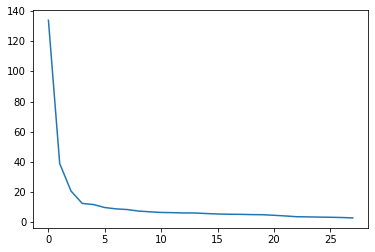

Energy up until 1 th singular value:  0.8589822466752967
Energy up until 2 th singular value:  0.9311203350630964
Energy up until 3 th singular value:  0.9513693000289403
Energy up until 4 th singular value:  0.9585881316825924
Energy up until 5 th singular value:  0.9649717527090856
Energy up until 6 th singular value:  0.9693517690320811
Energy up until 7 th singular value:  0.9729518165535392
0.0028485689390677082


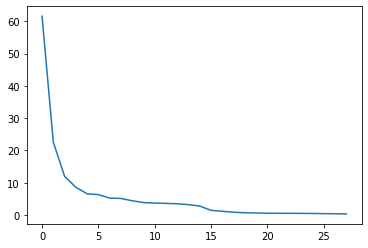

Energy up until 1 th singular value:  0.7974522455988441
Energy up until 2 th singular value:  0.9045232233844273
Energy up until 3 th singular value:  0.9347920049772268
Energy up until 4 th singular value:  0.9503831796962146
Energy up until 5 th singular value:  0.9594905115069434
Energy up until 6 th singular value:  0.9679240195535738
Energy up until 7 th singular value:  0.9737304686013524
0.002069916891254575


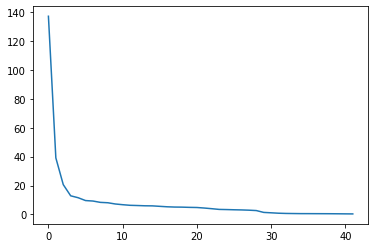

Energy up until 1 th singular value:  0.859656795228016
Energy up until 2 th singular value:  0.9296219217729459
Energy up until 3 th singular value:  0.9490443119825018
Energy up until 4 th singular value:  0.9566183333857605
Energy up until 5 th singular value:  0.9627255959347738
Energy up until 6 th singular value:  0.9669278023329062
Energy up until 7 th singular value:  0.9708438453396121
0.004956540152994848


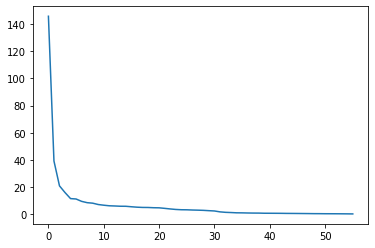

Energy up until 1 th singular value:  0.8665814223846152
Energy up until 2 th singular value:  0.9294603771075871
Energy up until 3 th singular value:  0.9473803305940064
Energy up until 4 th singular value:  0.9578710435611161
Energy up until 5 th singular value:  0.963355131734096
Energy up until 6 th singular value:  0.9685680238076878
Energy up until 7 th singular value:  0.972300906002448
0.003499479490158941
['3P_G', 'FG%', 'TOV_G', 'FT%']


In [141]:
metric_of_interest = "3P_G"
threshold = 0.97

############
df = donor.concat([metric_of_interest], 2016, total_index, method = mat_form_method)
apprx_rank = utils.approximate_rank(df, t = 0.97)
energy_captured = utils.svdAanlysis(df, title=metric_of_interest, verbose = False, k=apprx_rank)[apprx_rank-1]

metrics = [metric_of_interest]
candidates = copy.deepcopy(allMetrics)
candidates.remove(metric_of_interest)

while True:
    energy_diff_df = pd.DataFrame()
    for metric in candidates:
        comb = metrics+[metric]
        df = donor.concat(comb, 2016, total_index, method = mat_form_method)
        if (utils.approximate_rank(df, t = 0.97) == apprx_rank):
            energy_diff = np.abs(utils.svdAanlysis(df, k=apprx_rank, verbose=True)[-1] - energy_captured)
            energy_diff_df = pd.concat([energy_diff_df, pd.DataFrame([[energy_diff]], index=[metric])], axis=0)
            print(energy_diff)
    if (energy_diff_df.shape[0] == 0):
        break
    new_metric = energy_diff_df.sort_values(0).index[0]
    metrics = metrics + [new_metric]
    candidates.remove(new_metric)

print(metrics)

In [92]:
threshold = 0.97

for metric_of_interest in allMetrics:

    ############
    df = donor.concat([metric_of_interest], 2016, total_index, method = mat_form_method)
    apprx_rank = utils.approximate_rank(df, t = 0.97)
    energy_captured = utils.svdAanlysis(df, title=metric_of_interest, verbose = False)[apprx_rank-1]

    metrics = [metric_of_interest]
    candidates = copy.deepcopy(allMetrics)
    candidates.remove(metric_of_interest)

    while True:
        energy_diff_df = pd.DataFrame()
        for metric in candidates:
            comb = metrics+[metric]
            df = donor.concat(comb, 2016, total_index, method = mat_form_method)

            if (utils.approximate_rank(df, t = 0.97) == apprx_rank):

                energy_diff = np.abs(utils.svdAanlysis(df, k=apprx_rank, verbose=False)[-1] - energy_captured)
                energy_diff_df = pd.concat([energy_diff_df, pd.DataFrame([[energy_diff]], index=[metric])], axis=0)
    #             print(energy_diff)
        if (energy_diff_df.shape[0] == 0):
            break
        new_metric = energy_diff_df.sort_values(0).index[0]
        metrics = metrics + [new_metric]
        candidates.remove(new_metric)

    print(metric_of_interest)
    print(metrics)
    print()

PTS_G
['PTS_G', 'FG%', 'FT%', 'STL_G', 'TOV_G']

AST_G
['AST_G', 'PER_w', 'TOV_G', 'FG%', 'FT%', 'STL_G', 'BLK_G', '3P_G']

TOV_G
['TOV_G', 'PTS_G', 'BLK_G', 'FG%', 'FT%']

TRB_G
['TRB_G', 'FG%']

STL_G
['STL_G', 'FT%', 'FG%', 'TRB_G', 'PER_w', '3P_G', 'TOV_G', 'BLK_G']

BLK_G
['BLK_G', 'AST_G', 'FG%']

3P_G
['3P_G', 'FT%', 'FG%', 'TRB_G', 'BLK_G', 'PTS_G', 'PER_w', 'AST_G', 'STL_G']

FG%
['FG%', 'FT%', 'PER_w', 'STL_G']

FT%
['FT%', 'FG%', 'PER_w', 'STL_G']

PER_w
['PER_w', 'FG%', 'FT%', 'STL_G']



In [18]:
group1 = ["C", "SF","PF", "C-PF", "PF-C", "C-SF", "SF-C", "SF-PF", "PF-SF"]
group2 = ["SG","SF","PG", "SG-SF", "SF-SG", "SF-PG", "PG-SF", "SG-PG", "PG-SF"]
group3 = ["SG","SF","PF", "SG-SF", "SF-SG", "SF-PF", "PF-SF", "SG-PF", "PF-SG"]

donor_list = stats[stats.Pos.isin(group1)].Player.unique()
a = allPivotedTableDict['PTS_G'].index.isin(donor_list)
allPivotedTableDict['PTS_G'][a]

year_count,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,22
Player,,,,,,,,,,,,,,,,,,,,,
A.C. Green,6.353659,10.784810,11.426829,13.268293,12.939024,9.146341,13.609756,12.817073,14.682927,11.170732,...,7.317073,4.920000,5.036585,4.47561,NaN,NaN,NaN,NaN,NaN,NaN
A.J. Bramlett,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A.J. Hammons,2.181818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aaron Gordon,5.170213,9.217949,12.737500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aaron Gray,4.295082,3.500000,3.250000,3.146341,3.897959,2.833333,1.756757,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zarko Paspalj,2.571429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zaza Pachulia,3.288136,6.189189,11.679487,12.152778,5.193548,6.246753,4.269231,4.417722,7.844828,5.884615,...,8.552632,6.085714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zeljko Rebraca,6.932432,6.600000,3.791667,5.844828,4.655172,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def filterDonor(pivotedTableDict, donor_list):
    """
    pivotedTableDict: (dict) a dictionary of pivoted df's = {metric: df}
    donor_list: (list) list of the name of the players you want to include in the donor pool
    """
    dict_to_return = {}
    keys = allPivotedTableDict.keys()
    for key in keys:
        index_to_choose = allPivotedTableDict[key].index.isin(donor_list)
        dict_to_return.update(allPivotedTableDict[key][a])
    return dict_to_return

In [17]:
keys = allPivotedTableDict.keys()
for key in keys:
    print(key)

PTS_G
AST_G
TOV_G
TRB_G
STL_G
BLK_G
3P_G
FG%
FT%
PER_w


In [43]:
stats[stats.Player == "Anderson Varejao"]

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,PTS,year_start,year_end,position,height,weight,birth_date,college,player_id,year_count
9750,17601,2005,Anderson Varejao,PF,22.0,CLE,54.0,0.0,863.0,17.0,...,266.0,2005,2017,F-C,6-10,273.0,"September 28, 1982",NaN,2442,0
10304,18170,2006,Anderson Varejao,C,23.0,CLE,48.0,4.0,760.0,14.8,...,219.0,2005,2017,F-C,6-10,273.0,"September 28, 1982",NaN,2442,1
10811,18692,2007,Anderson Varejao,C,24.0,CLE,81.0,6.0,1932.0,14.4,...,547.0,2005,2017,F-C,6-10,273.0,"September 28, 1982",NaN,2442,2
11374,19269,2008,Anderson Varejao,C,25.0,CLE,48.0,13.0,1320.0,12.0,...,321.0,2005,2017,F-C,6-10,273.0,"September 28, 1982",NaN,2442,3
11958,19872,2009,Anderson Varejao,PF,26.0,CLE,81.0,42.0,2306.0,14.6,...,694.0,2005,2017,F-C,6-10,273.0,"September 28, 1982",NaN,2442,4
12530,20455,2010,Anderson Varejao,PF,27.0,CLE,76.0,7.0,2166.0,15.8,...,651.0,2005,2017,F-C,6-10,273.0,"September 28, 1982",NaN,2442,5
13126,21064,2011,Anderson Varejao,C,28.0,CLE,31.0,31.0,994.0,15.2,...,282.0,2005,2017,F-C,6-10,273.0,"September 28, 1982",NaN,2442,6
13673,21622,2012,Anderson Varejao,C,29.0,CLE,25.0,25.0,785.0,18.9,...,271.0,2005,2017,F-C,6-10,273.0,"September 28, 1982",NaN,2442,7
14245,22205,2013,Anderson Varejao,C,30.0,CLE,25.0,25.0,901.0,21.7,...,353.0,2005,2017,F-C,6-10,273.0,"September 28, 1982",NaN,2442,8
14837,22816,2014,Anderson Varejao,C,31.0,CLE,65.0,29.0,1800.0,17.0,...,546.0,2005,2017,F-C,6-10,273.0,"September 28, 1982",NaN,2442,9
